<a href="https://colab.research.google.com/github/yuvarbiv/DQN/blob/main/recreating_Baroch's_article.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports + print


In [ ]:
import random, math
import numpy as np
import matplotlib.pyplot as plt
import types
from matplotlib import animation
from IPython.display import HTML
from types import SimpleNamespace

# --------------------------------------------
def print_state(datasets, frame) :
  print(f"---------frame: {frame}-----------")
  print(f"grid:\n{datasets.grid}")
  print(f"agents_loc:\n{datasets.agents_loc}")
  print(f"----------------------------------")


#Per Cell Loop

In [ ]:
# --------------------------------------------
def inner_cell_loop(const_HP, var_HP, datasets, i, j, frame):
  datasets.cell_by_agent = []
  for a in datasets.agents_loc:
      d = np.hypot(a[0]-i, a[1]-j)
      s = cell_send_pulse(const_HP, var_HP, datasets, i, j) # Use current_alpha
      r = agent_recieved_signal(const_HP, var_HP, datasets, d) if s else 0 # Use current_lamda
      datasets.cell_by_agent.append(cell_update_probabillity(const_HP, var_HP, datasets, frame, datasets.grid[i][j], d, r))
  update_cell(const_HP, var_HP, datasets, i, j, frame)
  update_target_set(const_HP, var_HP, datasets, i, j, frame, datasets.grid[i][j]) # Use current_threshold

# --------------------------------------------
def cell_send_pulse(const_HP, var_HP, datasets, i, j):
  # return: 1==pulse, 0==no_pulse
  # later I'd like this function to return continuous value [0,1]
  if (i,j) in datasets.targets_loc:        return random.random() < const_HP.P_ta
  if (i,j) in datasets.false_targets_loc:  return random.random() < var_HP.alpha*const_HP.P_ta
  return False

# --------------------------------------------
def agent_recieved_signal(const_HP, var_HP, datasets, d):
  # return: 1==pulse, 0==no_pulse
  # TODO: later I'd like this function to return continuous value [0,1]
  x = math.e**(-d/var_HP.lamda)
  return random.random() < x

# --------------------------------------------
def cell_update_probabillity(const_HP, var_HP, datasets, frame, prev_grid_val, d, recieved):
  min_value = 0.01
  P_recieved__t0 = prev_grid_val
  NP_recieved__t0 = 1-P_recieved__t0
  # recieved
  numerator =             P_recieved__t0 * const_HP.P_ta
  denumerator = numerator + NP_recieved__t0 * const_HP.P_ta * var_HP.alpha
  P_signal_recieved__t1 = numerator / denumerator if denumerator != 0 else min_value # Avoid division by zero
  # UNrecieved
  signal_strength = 1-math.e**(-d/var_HP.lamda)
  numerator =           P_recieved__t0 * (const_HP.NP_ta + const_HP.P_ta*signal_strength)
  denumerator = numerator + NP_recieved__t0 * ((1-var_HP.alpha*const_HP.P_ta)+var_HP.alpha*const_HP.P_ta*signal_strength)
  P_signal_UNrecieved__t1 = numerator / denumerator if denumerator != 0 else min_value # Avoid division by zero

  if recieved:
    return max(P_signal_recieved__t1,min_value) # Using the calculated received probability
  else:
    return max(P_signal_UNrecieved__t1,min_value) # Using the calculated unreceived probability

# --------------------------------------------
def update_cell(const_HP, var_HP, datasets, i, j, frame):
  new_val = np.mean(datasets.cell_by_agent)
  datasets.grid[i][j] = new_val

# --------------------------------------------
def update_target_set(const_HP, var_HP, datasets, i, j, frame, new_grid_val):
  if new_grid_val >= var_HP.threshold and (i,j) not in [(t[0], t[1]) for t in datasets.target_set]:
    datasets.target_set.add((i,j,frame))
    datasets.detect_img[i, j] = frame  # reflect into detection image
    pairs,frame = print_targets_found(datasets)

# --------------------------------------------
def print_targets_found(datasets):
  pairs = [f"({i}),({j})" for i,j, _ in datasets.target_set]
  steps = [steps for _, _, steps in datasets.target_set]
  return pairs,steps


#Agent Movement

In [ ]:
# --------------------------------------------
def move_all_agents(const_HP, var_HP, datasets):
  agents_COM = calc_agents_COM(const_HP, var_HP, datasets)
  entropy_COM = calc_entropy_COM(datasets.grid)

  if const_HP.print:
    print(datasets.grid)
    print(f"entropy_COM: {entropy_COM}")
  for a in range(const_HP.nof_agents):
    move_agent(const_HP, var_HP, datasets, a, agents_COM, entropy_COM)

# --------------------------------------------
def calc_agents_COM(const_HP, var_HP, datasets):
  # agents center of mass
  # agents_array = np.array(datasets.agents_loc)
  # return np.full(const_HP.nof_agents, agents_array.mean(axis=0))   # average over rows

  # nearest agent TODO treat the case of 1 agent
  nearest = []
  for a in range(const_HP.nof_agents):
    nearest_dist = const_HP.GSize**2
    nearest_agent_loc = None  # Initialize to None or some indicator
    my_loc = datasets.agents_loc[a]
    for n in range(const_HP.nof_agents):
      dist = ((datasets.agents_loc[a][0] - datasets.agents_loc[n][0])**2 + (datasets.agents_loc[a][1] - datasets.agents_loc[n][1])**2)**0.5
      if dist < nearest_dist and n != a:
        nearest_dist = dist
        nearest_agent_loc = datasets.agents_loc[n] # Store the location directly
    nearest.append(nearest_agent_loc) # Append the nearest agent's location

  return nearest

# --------------------------------------------
def calc_entropy_COM(grid, baseline_p=0.01, eps=1e-9):
    H = bernoulli_entropy(grid)
    H_base = bernoulli_entropy(baseline_p)        # scalar
    w = H - H_base                                # excess entropy
    w[w < eps] = 0.0                              # kill numerical noise
    if w.sum() == 0:
        return (-1,-1)
    rows, cols = np.indices(w.shape)
    y_cm = (rows * w).sum() / w.sum()
    x_cm = (cols * w).sum() / w.sum()
    return (y_cm, x_cm)

# --------------------------------------------
def bernoulli_entropy(p):
    p = np.clip(p, 1e-12, 1-1e-12)
    return -(p*np.log2(p) + (1-p)*np.log2(1-p))

# --------------------------------------------
def move_agent(const_HP, var_HP, datasets, agent_num, agents_COM, entropy_COM):
  # Pass the location of the current agent's nearest neighbor
  datasets.agents_loc[agent_num] = next_location(datasets, agent_num, agents_COM[agent_num], entropy_COM, datasets.grid.shape, 1)

# --------------------------------------------
def next_location(datasets, agent_num, nearest_agent_loc, entropy_COM, grid_shape, k=0.5):
    """
    o: (i,j) current location
    x: (i,j) location to avoid (nearest agent)
    y: (i,j) location to approach (entropy COM)
    grid_shape: (rows, cols)
    k: weighting factor (importance of avoiding x vs. approaching y)
       k > 1 -> stronger avoidance of x
       k < 1 -> stronger pull toward y
    """
    o = datasets.agents_loc[agent_num]
    oi, oj = o
    rows, cols = grid_shape

    neighbors = [
        (oi+di, oj+dj)
        for di in [-1, 0, 1]
        for dj in [-1, 0, 1]
    ]

    # keep inside boundaries
    neighbors = [(i, j) for i, j in neighbors if 0 <= i < rows and 0 <= j < cols]

    def score(loc):
        i, j = loc
        # print(i,j,nearest_agent_loc,entropy_COM)
        d_y = np.hypot(i - entropy_COM[0], j - entropy_COM[1])   # distance to y
        # Check if nearest_agent_loc is not None before accessing its elements
        if nearest_agent_loc is not None:
            d_x = np.hypot(i - nearest_agent_loc[0], j - nearest_agent_loc[1])   # distance to x
        else:
            d_x = 0 # Or handle this case as appropriate for your logic

        return -d_y + k * d_x

    # Handle the case where neighbors is empty (e.g., 1x1 grid)
    if not neighbors:
        return o  # Stay at the current location if no neighbors are available

    best = max(neighbors, key=score)
    return best

#Animation

In [ ]:
# --------------------------------------------
def set_images(const_HP, var_HP, datasets, Gim, Tim):
  # global texts  # Declare texts as global

  # Clear previous texts
  texts = []
  # for text in texts:
      # text.remove()

  # update agent scatters on both axes
  ax = [c[1] for c in datasets.agents_loc]  # x = col (j)
  ay = [c[0] for c in datasets.agents_loc]  # y = row (i)
  xy = np.column_stack([ax, ay])            # shape (N, 2)
  agents_scatter_T.set_offsets(xy)

  # update both images
  Gim.set_data(datasets.grid)
  Tim.set_data(datasets.detect_img)

  # Add text annotations for detected targets
  for i in range(const_HP.GSize):
    for j in range(const_HP.GSize):
      if datasets.detect_img[i, j] > 0:
        text = Tax.text(j, i, int(datasets.detect_img[i, j]), ha="center", va="center", color="black")
        texts.append(text)

  # return a FLAT list of artists
  return [Gim, Tim] + texts


#1 RUN + SIMULATION

/tmp/ipython-input-727135638.py:91: UserWarning: frames=<function <lambda> at 0x7d49f8b4d760> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  anim = animation.FuncAnimation(


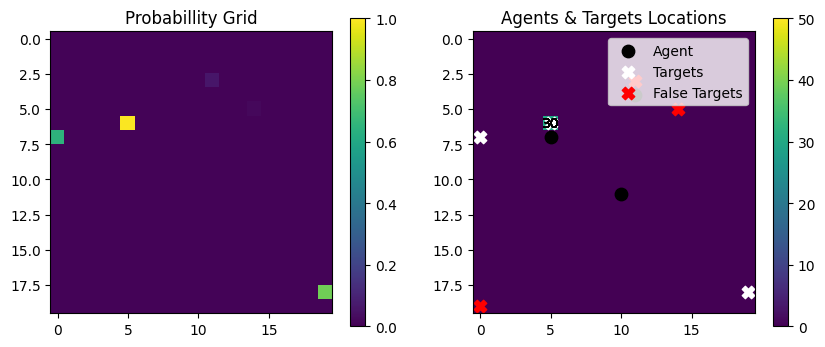

In [ ]:
# ----- model hyper-parameters -----
seed = 42
random.seed(seed)
np.random.seed(seed)

const_HP = SimpleNamespace()
const_HP.P_ta = 1
const_HP.NP_ta = 1 - const_HP.P_ta
const_HP.nof_iterations = 50
const_HP.nof_agents = 3
const_HP.nof_targets = 3
const_HP.nof_false_targets = 3
const_HP.GSize = 20
const_HP.print = False
var_HP = SimpleNamespace()
var_HP.threshold = 0.9
var_HP.alpha = 0.5
var_HP.lamda = 10

# ----- initialize datasets -----
datasets = SimpleNamespace()
datasets.grid = np.full((const_HP.GSize, const_HP.GSize), const_HP.nof_targets/(const_HP.GSize**2), dtype=float)
datasets.agents_loc = random.sample([(i,j) for i in range(const_HP.GSize) for j in range(const_HP.GSize)], const_HP.nof_agents)
datasets.targets_loc = random.sample([(i,j) for i in range(const_HP.GSize) for j in range(const_HP.GSize)], const_HP.nof_targets)
datasets.available_locs = [(i,j) for i in range(const_HP.GSize) for j in range(const_HP.GSize) if (i,j) not in datasets.targets_loc]
datasets.false_targets_loc = random.sample(datasets.available_locs, const_HP.nof_false_targets)
datasets.target_set = set()
datasets.detect_img = np.zeros_like(datasets.grid, dtype=float)
if const_HP.print:
  print(datasets.grid)
  print(datasets.agents_loc)
  print(datasets.targets_loc)
  print(datasets.false_targets_loc)
  print(datasets.target_set)
  print(datasets.detect_img)

# ---- single figure, two axes ----
fig, (Gax, Tax) = plt.subplots(1, 2, figsize=(10, 4))

Gim = Gax.imshow(datasets.grid, cmap='viridis', vmin=0, vmax=1)
Gax.set_title('Probabillity Grid'); fig.colorbar(Gim, ax=Gax)
Tim = Tax.imshow(datasets.detect_img, cmap='viridis', vmin=0, vmax=const_HP.nof_iterations) # Changed vmax to nof_iterations
Tax.set_title('Agents & Targets Locations'); fig.colorbar(Tim, ax=Tax)

# draw static markers once
ax = [c[1] for c in datasets.agents_loc]; ay = [c[0] for c in datasets.agents_loc]
agents_scatter_T = Tax.scatter(ax, ay, marker='o', s=80, color='black', label='Agent')
tx = [c[1] for c in datasets.targets_loc]; ty = [c[0] for c in datasets.targets_loc]
Tax.scatter(tx, ty, marker='X', s=80, color='white', label='Targets')
fx = [c[1] for c in datasets.false_targets_loc]; fy = [c[0] for c in datasets.false_targets_loc]
Tax.scatter(fx, fy, marker='X', s=80, color='red', label='False Targets')
Tax.legend(loc='upper right')

# ----- main loop -----
def update(frame):
  if const_HP.print:
    print_state(datasets, frame)

  # # Check stopping condition at the beginning of the frame
  # datasets.detected_target_locations = [(t[0], t[1]) for t in datasets.target_set]
  # all_targets_detected = all(target in datasets.detected_target_locations for target in datasets.targets_loc)

  # set stop when all targets found:
  detected = {(i, j) for i, j, _ in datasets.target_set}
  if detected.issuperset(datasets.targets_loc):
      print(f"All targets found at frame {frame}")
      stop_flag["stop"] = True

  # 1 step for every cell for all agents
  for i in range(const_HP.GSize):
    for j in range(const_HP.GSize):
      inner_cell_loop(const_HP, var_HP, datasets, i, j, frame)

  # Move the agents
  move_all_agents(const_HP, var_HP, datasets)

  # Update images and texts for the current frame
  artists = set_images(const_HP, var_HP, datasets, Gim, Tim)

  return artists

stop_flag = {"stop": False}  # mutable flag shared with update()
def frame_gen(max_frames):
    f = 0
    while f < max_frames and not stop_flag["stop"]:
        yield f
        f += 1

# ----- run -----
# Build animation with generator (not a fixed range)
anim = animation.FuncAnimation(
    fig, update, frames=lambda: frame_gen(const_HP.nof_iterations),
    interval=200, blit=False
)
HTML(anim.to_jshtml())

# Multiple Runs, no simulation

this version gets the constant hyper-parameters(HP):
1. nof_runs (number of runs)
2. max_frames
3. gridsize
4. nof_agents
5. nof_targets
6. nof_false_targets

and the varying-HP:
1. alpha
2. lambda
3. threshold


It then iterates over the varying-HP and tries to find the {max-alpha, min-lambda, max-threshold} combination that would still find all targets withough finding false-targets.

In [ ]:
import pandas as pd

# List to store results from each run
datasets.results = []

const_HP.nof_runs = 1
const_HP.max_frames = 2
const_HP.GSize = 80
# Randomize hyperparameters (example ranges, adjust as needed)
var_HP.alpha = 0.3#0.50 #0.53 #random.uniform(0.1, 0.95)
var_HP.lamda = 20#14.52 #random.uniform(5, 20)
var_HP.threshold = 0.9#0.78 #random.uniform(0.7, 0.95)
all_targets_detected = False
reached_undetection = 3

for run in range(const_HP.nof_runs):
    print(f"Starting run {run + 1}/{const_HP.nof_runs} with lamda {var_HP.lamda}")

    # Reset variables for each run
    datasets.grid = np.full((const_HP.GSize, const_HP.GSize), const_HP.nof_targets/(const_HP.GSize**2), dtype=float)
    # Re-randomize agent, target, and false target locations for each run
    datasets.agents_loc = random.sample([(i,j) for i in range(const_HP.GSize) for j in range(const_HP.GSize)], const_HP.nof_agents)
    datasets.targets_loc = random.sample([(i,j) for i in range(const_HP.GSize) for j in range(const_HP.GSize)], const_HP.nof_targets)
    datasets.available_locs = [(i,j) for i in range(const_HP.GSize) for j in range(const_HP.GSize) if (i,j) not in datasets.targets_loc]
    datasets.false_targets_loc = random.sample(datasets.available_locs, const_HP.nof_false_targets)

    datasets.detect_img = np.zeros_like(datasets.grid, dtype=float)
    datasets.target_set = set()
    frames_taken = 0
    false_target_detected = False # Flag to indicate if a false target was detected

    # --- Simulation loop for a single run ---
    for frame in range(const_HP.max_frames):
        # Step model once (copying logic from the previous update function)
        for i in range(const_HP.GSize):
            for j in range(const_HP.GSize):
                datasets.cell_by_agent = []
                for a in datasets.agents_loc:
                    d = np.hypot(a[0]-i, a[1]-j)
                    s = cell_send_pulse(const_HP, var_HP, datasets, i, j) # Use current_alpha
                    r = agent_recieved_signal(const_HP, var_HP, datasets, d) if s else 0 # Use current_lamda
                    datasets.cell_by_agent.append(cell_update_probabillity(const_HP, var_HP, datasets, frame, datasets.grid[i][j], d, r))
                update_cell(const_HP, var_HP, datasets, i, j, frame)
                update_target_set(const_HP, var_HP, datasets, i, j, frame, datasets.grid[i][j]) # Use current_threshold

        frames_taken = frame + 1

        # Move the agents
        move_all_agents(const_HP, var_HP, datasets)

        # Check stopping condition
        datasets.detected_target_locations = [(t[0], t[1]) for t in datasets.target_set]
        if all(target in datasets.detected_target_locations for target in datasets.targets_loc):
            print(f"All targets detected in run {run + 1} at frame {frames_taken}")
            break

        # Check if any detected location is a false target
        if any(datasets.detected_loc in datasets.false_targets_loc for datasets.detected_loc in datasets.detected_target_locations):
            false_target_detected = True
            print(f"False Target detected in run {run + 1} at frame {frames_taken}")
            break

    # --- Collect results for the run ---
    last_detected_target_frame = -1
    last_detected_target_loc = None
    if datasets.target_set:
        # Find the target that was discovered last
        # Filter out false targets before finding the last detected true target
        datasets.true_targets_detected = [t for t in datasets.target_set if (t[0], t[1]) in datasets.targets_loc]
        if datasets.true_targets_detected:
          last_detected_target_info = max(datasets.true_targets_detected, key=lambda item: item[2])
          last_detected_target_loc = (last_detected_target_info[0], last_detected_target_info[1])
          last_detected_target_frame = last_detected_target_info[2]


    avg_agent_distance_to_last_target = -1
    if last_detected_target_loc:
        distances = [np.hypot(a[0] - last_detected_target_loc[0], a[1] - last_detected_target_loc[1]) for a in datasets.agents_loc]
        avg_agent_distance_to_last_target = np.mean(distances)

    all_targets_detected = all(target in datasets.detected_target_locations for target in datasets.targets_loc)
    if not all_targets_detected : reached_undetection = 1
    print(f"reached_undetection: {reached_undetection}")
    print(f"all_targets_detected: {all_targets_detected}")

    datasets.results.append({
        'run': run + 1,
        'nof_agents': const_HP.nof_agents,
        'nof_targets': const_HP.nof_targets,
        'alpha': var_HP.alpha,
        'lamda': var_HP.lamda,
        'threshold': var_HP.threshold,
        'frames_to_detect_all': frames_taken if all_targets_detected else -1, # -1 if not all detected
        'avg_agent_distance_to_last_target': avg_agent_distance_to_last_target,
        'false_target_detected': false_target_detected # Add the false target detection flag
    })

    for i in range(reached_undetection) :
      choose_hyper = 1#random.choice([0,1,2])
      match choose_hyper:
        case 0:   var_HP.alpha += 0.01 if all_targets_detected else -0.01
        case 1:   var_HP.lamda += -0.1 if all_targets_detected else 0.1
        case 2:   var_HP.threshold += 0.01 if all_targets_detected else -0.01
        case _:   print('ERROR')

# Convert results to a pandas DataFrame
results_df = pd.DataFrame(datasets.results)

# Display the results
display(results_df)